# Cross validation

## I) Imports

In [61]:
from proj1_helpers import *
from custom_helpers import *
from implementations import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II) Required functions

In [2]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [75]:
def cross_validation(x, y, flag_method, degree, lambda_=0, gamma=1.e-6, max_iters=1000, k_fold=int(5), seed=143225):
    "Train the model and evaluate loss based on cross validation"
    mses_tr = []
    mses_te = []
    
    k_indices = build_k_indices(y, k_fold, seed);
    for i in range(k_fold):
        newk_index = np.delete(k_indices, i, 0)
        indices_train = newk_index.ravel()
        indices_test = k_indices[i]

        # Train data at each iteration "i" of the loop
        x_train = x[indices_train]
        y_train = y[indices_train]

        # Validate the data at each iteration "i" of the loop
        x_test = x[indices_test]
        y_test = y[indices_test]

        # Prepare data (Standardisation and offset)
        training_tx, testing_tx = prepare_data(x_train, x_test, True, True, True, degree)
        
        # create initial w for methods using it
        initial_w = np.zeros(training_tx.shape[1])

        if flag_method == 0:
            # Use linear regression (full gradient descent)
            weight, loss_tr = least_squares_GD(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 1:
            # Use linear regression (stochastic gradient descent)
            weight, loss_tr = least_squares_SGD(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 2:
            # Use least squares method
            weight, loss_tr = least_squares(y_train, training_tx)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 3:
            # Use ridge regression
            weight, loss_tr = ridge_regression(y_train, training_tx, lambda_)
            loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
            
        if flag_method == 4:
            # Use logistic regression
            y_train[np.where(y_train == -1)] = 0
            y_test[np.where(y_test == -1)] = 0
            weight, loss_tr = logistic_regression(y_train, training_tx, initial_w, max_iters, gamma)
            loss_te = calculate_log_loss(y_test, testing_tx, weight)
            
        if flag_method == 5:
            # Use regularized logistic regression
            y_train[np.where(y_train == -1)] = 0
            y_test[np.where(y_test == -1)] = 0
            weight, loss_tr = reg_logistic_regression(y_train, training_tx, initial_w, max_iters, gamma, lambda_)
            loss_te = calculate_log_loss(y_test, testing_tx, weight)
        
        # Append loss of this round to list
        mses_tr.append(loss_tr)
        mses_te.append(loss_te)


    loss_tr = np.mean(mses_tr)
    loss_te = np.mean(mses_te)
    return loss_tr, loss_te

## III) Main
### Load the data

In [4]:
# Loading Data
print("Loading Data, please wait")
train_y, train_x, ids_train = load_csv_data('data/train.csv')
print("Data loaded, continue!!")

Loading Data, please wait
Data loaded, continue!!


In [43]:
"""
Methods mapping
0    Linear regression (full gradient descent)
1    Linear regression (stochastic gradient descent)
2    Least squares method
3    Ridge regression
4    Logistic regression (stochastic gradient descent)
5    Regularized logistic regression (stochastic gradient descent)

"""

'\nMethods mapping\n0    Linear regression (full gradient descent)\n1    Linear regression (stochastic gradient descent)\n2    Least squares method\n3    Ridge regression\n4    Logistic regression (stochastic gradient descent)\n5    Regularized logistic regression (stochastic gradient descent)\n\n'

### Cross validation for methods without regularisation
Test polynominal expansion of different degrees

In [81]:
# Chose learnig method to use (see mapping above)
flag_method = 4;

# set Gradient descent parameters
gamma = 0.001
max_iters = 3000

# Define range for the polynomial expansion
degree_range = np.arange(1, 5)

train_losses = np.zeros(len(degree_range))
test_losses = np.zeros(len(degree_range))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, 0, gamma, max_iters)
    print("For the Degree: %d , The LOSS is : %f" %(degree, loss_te))
    train_losses[ind_degree] = loss_tr
    test_losses[ind_degree] = loss_te
print("Cross Validation finished!!")
best_value = np.unravel_index(np.argmin(test_losses), test_losses.shape)
print("The best degrees are: ", degree_range[best_value])

iteration	 0 	loss:  0.013862943611198907
iteration	 50 	loss:  0.6801596150226012
iteration	 100 	loss:  0.663426087333487
iteration	 150 	loss:  0.6544651410379625
iteration	 200 	loss:  0.6493302832703728
iteration	 250 	loss:  0.6461117989603715
iteration	 300 	loss:  0.6438754449520612
iteration	 350 	loss:  0.642157834001262
iteration	 400 	loss:  0.640725962942263
iteration	 450 	loss:  0.639461089715844
iteration	 500 	loss:  0.6383018063724722
iteration	 550 	loss:  0.6372157513371817


KeyboardInterrupt: 

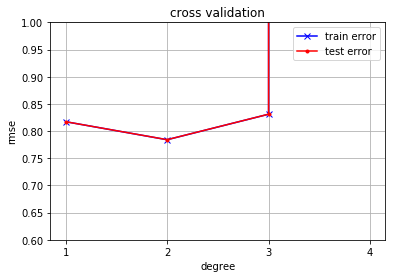

In [77]:
# Visualize
cross_validation_visualization_degree(degree_range, train_losses, test_losses)

### Cross validation for Methods using regularisation
Grid search over different degrees of polynominal expansion and for different lambdas

In [82]:
# Chose learnig method to use (see mapping above)
flag_method = 3;

# set Gradient descent parameters
gamma = 0.001
max_iters = 3000

# Define range for the polynomial expansion and for lambda
degree_range = np.arange(2, 3)
lambda_range = np.arange(0.0, 1.6e-12, 1.e-13)

train_losses_matrix = np.zeros((len(degree_range), len(lambda_range)))
test_losses_matrix = np.zeros((len(degree_range), len(lambda_range)))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain = remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    for ind_lambda_, lambda_ in enumerate(lambda_range):
        loss_tr, loss_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_, gamma, max_iters)
        print("For the Degree: %d and lambda %.2E, The LOSS is : %f" %(degree, lambda_, loss_te))
        train_losses_matrix[ind_degree, ind_lambda_] = loss_tr
        test_losses_matrix[ind_degree, ind_lambda_] = loss_te

print("Cross Validation finished!!")
best_value = np.unravel_index(np.argmin(test_losses_matrix), test_losses_matrix.shape)
print(best_value)
print("Best degree: %d, with lambda %f " %(degree_range[best_value[0]], lambda_range[best_value[1]]))

For the Degree: 2 and lambda 0.00E+00, The LOSS is : 0.784160
For the Degree: 2 and lambda 1.00E-13, The LOSS is : 0.784159
For the Degree: 2 and lambda 2.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 3.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 4.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 5.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 6.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 7.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 8.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 9.00E-13, The LOSS is : 0.784159
For the Degree: 2 and lambda 1.00E-12, The LOSS is : 0.784160
For the Degree: 2 and lambda 1.10E-12, The LOSS is : 0.784160
For the Degree: 2 and lambda 1.20E-12, The LOSS is : 0.784161
For the Degree: 2 and lambda 1.30E-12, The LOSS is : 0.784162
For the Degree: 2 and lambda 1.40E-12, The LOSS is : 0.784163
For the Degree: 2 and lambda 1.50E-12, The LOSS is : 0.784164
Cross Va

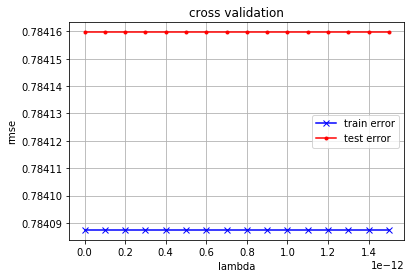

In [79]:
# Visualize
cross_validation_visualization(lambda_range, train_losses_matrix[0, :], test_losses_matrix[0, :])